<a href="https://colab.research.google.com/github/enriquecorimayo/Doctorado/blob/dev/GGAL_an%C3%A1lisis_de_opciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://santanderpost.com.ar/articulo/web-scraping-la-herramienta-para-recolectar-datos-y-aumentar-el-valor-a-tu-servicio/

<html>
  <head>
    <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1">
    <!-- CSS -->
    <link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.7.2/css/all.css" integrity="sha384-fnmOCqbTlWIlj8LyTjo7mOUStjsKC4pOpQbqyi7RrhN7udi9RwhKkMHpvLbHG9Sr" crossorigin="anonymous">
	

	<!-- JAVASCRIPT -->
	<!--[if lt IE 9]>
	      <script src="http://html5shim.googlecode.com/svn/trunk/html5.js"></script>
	<![endif]-->
	<!-- Favicons -->
	<link rel="shortcut icon" href="https://santanderpost.com.ar/wp-content/themes/santanderpost/img/global/favicon.ico">
	<link rel="apple-touch-icon-precomposed" href="https://santanderpost.com.ar/wp-content/themes/santanderpost/img/global/favicon.ico">
	<link rel="apple-touch-icon-precomposed" sizes="72x72" href="https://santanderpost.com.ar/wp-content/themes/santanderpost/img/global/favicon.ico">

    <meta name='robots' content='index, foll

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Instalar yfinance para descargar precios de YahooFinance
# !pip install yfinance # INSTALAR

from plotly.offline import init_notebook_mode, iplot
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import statsmodels.api as sm
from matplotlib.pyplot import figure
import pylab
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from datetime import date
from google.colab import output
from pandas_profiling import ProfileReport
plt.rcParams.update({'figure.max_open_warning': 0})
output.enable_custom_widget_manager()

**Analizando la dinámica de los retornos de Galicia**

Como la mayoría de los traders de opciones saben, modelos de opciones clásicos como BSM tienen  supuestos que pueden llegar a ser más o menos realistas dependiendo de la dinámica del mercado. Uno de ellas es el supuesto de *normalidad en los retornos*. Veamos por medio de diversos tests que este supuesto no se satisface en absoluto en Arg (ni en cualquier mercado del mundo!)

In [ ]:
# descargamos GGAL (ADR) de los últimos 10 años
data = yf.download('GGAL', period = "10Y" ,auto_adjust = True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# preparemos la data
data = data.drop('Volume', axis = 1) # por ahora, no usaremos el volumen
retornos = data.pct_change() # retornos
retornos = retornos.add_suffix('Rets') # agregamos el suffix "Rets"
retornos = retornos.dropna()
retornos.head()

,OpenRets,HighRets,LowRets,CloseRets
Date,,,,
2012-11-01,-0.017241,-0.017241,-1.004035e-02,-0.009901
2012-11-02,-0.023392,-0.013645,-1.014197e-02,-0.010000
2012-11-05,-0.023952,-0.021739,-1.434419e-02,-0.016161
2012-11-06,-0.012270,0.002020,-1.088372e-07,0.016427
2012-11-07,0.004141,-0.012097,-1.039477e-02,-0.026262


Plotemos los precios de cierre y retornos para entender el proceso del activo subyacente.

In [ ]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x = data.index,
               y = data['Close'].values,
               name = 'Precio de cierre (ajustado)'),
    row=1, col=1 
    )

fig.add_trace(
    go.Scatter(x = retornos.index, 
               y = retornos['CloseRets'].values,
               name = 'Retornos diarios'),
    row = 2, col = 1,
    )

# fn para hacer interactivo el chart. I.e., seleccionar el periodo que deseamos
fig.update_xaxes(
    matches = 'x',
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=list([ # agregamos los botones (1m, 6m, YTD, 1Y, all)
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Con solo ver el chart, podemos notar varios puntos:


1.   **Volatility clustering** periodos de alta volatilidad tienden a agruparse, exhibiendo autocorrelación positiva.
2.   **Volatility leverage:** correlación negativa entre retornos y volatilidad (esto puede variar dependiendo del spot/vol dynamics)
3.   **Vol-of-vol:** lejos de ser constante, la volatilidad presenta alta volatilidad.
2.   **Fat Tails:** podemos ver fuertes observaciones (principalmente a la baja, debido a la asimetría).

Todo esto evidencia lo lejos que están los retornos de los activos (en este caso, GGAL) de comportarse de forma normal. Veamos un chart de la densidad.

In [ ]:
# veamos un histograma de los retornos
X = []
X.append( retornos['CloseRets'].dropna() ) 
group_labels = ['CloseRets']
fig = go.FigureWidget( 
    ff.create_distplot( X, group_labels, 
                       show_hist=False, 
                      #  curve_type = 'normal',
                       show_rug=False )  
    )
fig.update_layout(title_text='Presente Fat Tail con gran Asimetría')
fig.show()

Reiterando lo de arriba, vemos que tiene **fat tails** y una fuerte asimetría hacia el downside. Esta es una característica típica de los retornos de activos financieros, más aún en mercados emergentes plagados de eventos negativos con baja liquidez. 

Adicionalmente, podemos correr algún análisis típico para testear la normalidad de los retornos. Hay muchos. Corramos algunos clásicos:



*   **Quantile-Quantile Plot:** comparamos la distribución teórica con la distribución empírica del activo bajo análisis y vemos que tan alejados están los cuantiles entre ambas variables.
*   **Box and Whisker plot:** chequeamos en donde se ubica la media y la mediana, así como también la asimetría. Tampoco deberíamos ver outliers.
*  **Shapiro-Wilk Test:** calculamos el estadístico como:
>   $W=\frac{\left(\sum_{i=1}^{n} a_{i} x_{(i)}\right)^{2}}{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}}$

En donde $x_i$ son las observaciones ordenadas de menor a mayor, $\bar{x}$ es la media muestral. Por más detalles, ver [Shapiro-Wilk-Test](https://www.sciencedirect.com/topics/psychology/shapiro-wilk-test).
*Interpretación*: plantemos $H_0: ~\mathcal{N}(...)$. Si p-value < $\alpha$  (nivel de significancia), rechazamos $H_0$ y concluímos que los datos no vienen de una distribución normal




---



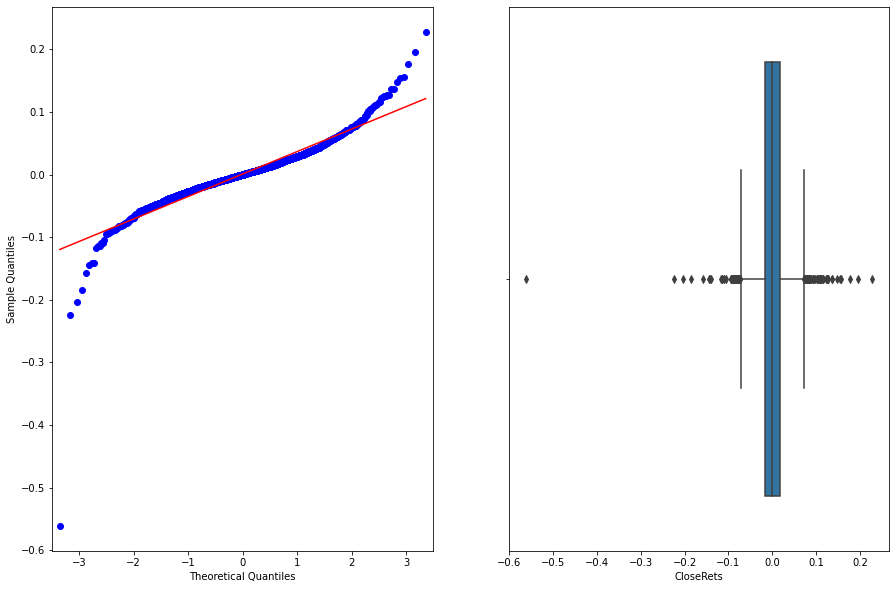

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

test = retornos['CloseRets']

sm.qqplot(ax=axes[0], data = test, line = 's')
ax = sns.boxplot(ax=axes[1], x = test)

fig.show()

En ambos charts podemos ver fat tails, gran asimetría, reconfirmando la no normalidad en los retornos.

In [ ]:
from scipy.stats import shapiro

# corremos el test de shapiro
stat, p = shapiro(test)

# armamos una tabla para visualizar
result_mat = [
    ['# Obs', 'Estadística', 'P-value'],
    [len(test), np.round( stat, 3 ), np.round( p, 3 ) ]
]

swt_table = ff.create_table(result_mat)

swt_table

**Resultado:** rechazamos $H_0$  y concluímos que los datos no vienen de una distribución normal

# **Modelo Black-Scholes-Merton (BSM) para opciones vanilla**

Comencemos definiendo uno de los parámetros más importantes (y difíciles de estimar en la practica) al momento de valuar opciones. **Volatilidad**, la cual tiene diversas formar de interpretar y estimar. *Volatilidad histórica* (desvío estándar), *volatilidad instantanea*, es decir, el parámetro difusivo del proceso estocástico, *volatilidad implícita*, entre otras. Definamos el proceso del activo subyacente - stochastic differential equation:

>   $dS_t = rS_t + \sigma S_t dZ_t$

Como la mayoría de los traders de opciones saben, tiene diversos supuestos que pueden llegar a ser más o menos realistas dependiendo de la dinámica del mercado. Uno de ellas es el supuesto de *normalidad en los retornos*. Vimos por medio de diversos tests que este supuesto no se satisface.

**Definamos la función Black-Scholes con dividendos (Warning! para europeas)**

In [ ]:
from scipy.stats import norm
N = norm.cdf
def black_scholes(S, K, tt, r , q, σ):
    """
    Black-scholes con dividendos
    Inputs
    S = Precio del Subyacente 
    K = Strike
    tt = Maturity
    r = Tasa libre de riesgo
    q = Tasa de dividendos
    σ = volatiliddad
    """
    # típicas funciones d1 y d2 
    
    d1 = (np.log(S / K) + (r - q + 0.5 * σ ** 2) * tt) / (σ * np.sqrt(tt))
    d2 = (np.log(S / K) + (r - q - 0.5 * σ ** 2) * tt) / (σ * np.sqrt(tt))
    
    put = (K * np.exp(-r * tt) * N(-d2, 0.0, 1.0) - S * np.exp(-q * tt) * N(-d1, 0.0, 1.0))
    return put

# **Modelo Alternativo: Proceso Jump Diffusion SDE**
Los precios de activos financieros, empíricamente, exhiben saltos y discontinuidades que son imposibles de modelar con un movimiento geométrico browniano (Black-Scholes).

Es por ello que esta extensión Black-Scholes tiene como objetivo incorporar supuestos un tanto más realistas. Entre otras cosas, relajar el supuesto de varianza constante y distribución normal. Así mismo, en un mundo Black-Scholes no tendríamos volatility smile (aunque para equity la smile no es tan smile :)).

$$ \ln \left(S_{T}\right)=\ln (S)+\int_{0}^{t}\left(r-\frac{\sigma^{2}}{2} - Λ \left(\xi + \frac{v^2}{2}\right)\right) d t+\int_{0}^{t} \sigma d W(t)+\sum_{j=1}^{N_{t}}\left(Q_{j}-1\right) $$

En donde $N(t)$ es un proceso de Poison con probabilidad de que ocurran $k$ saltos durante la vida de la opción. $Q_{j}$ es una variable aleatorible con distro log-normal. Λ es la intensidad de los saltos y $\xi$ es la media de los saltos y $v$ es desvío de los saltos.

Como podemos ver, necesitamos estimar varios parámetros para simular este proceso. Si bien, abajo vamos a simular el proceso, existe una closed-form solution para esto.

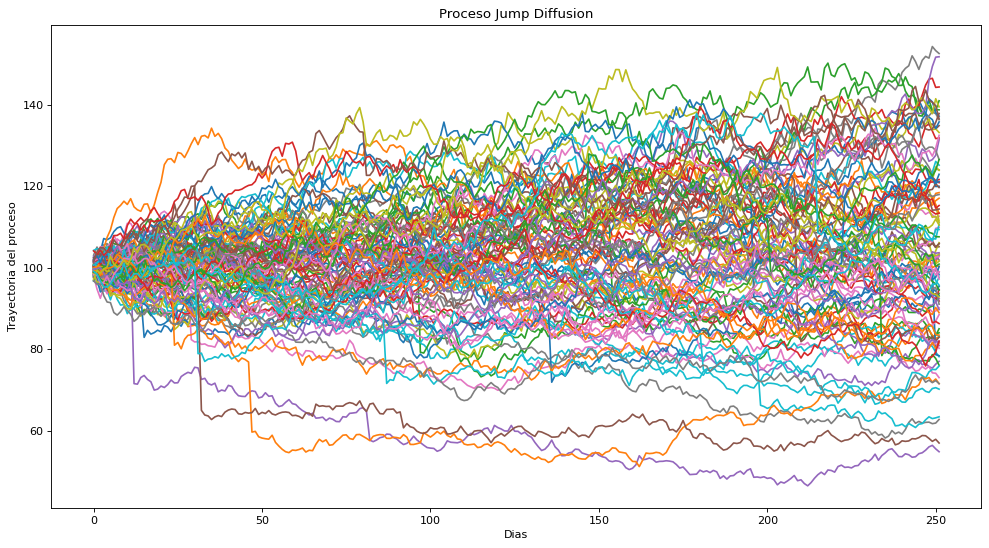

In [ ]:
def simulacion_jumps(S, tt, r, q, σ, Λ, ξ, v, steps, Npaths):
    """
    Simular paths con jumps
    Inputs
    S = Precio del Subyacente 
    K = Strike
    tt = Maturity
    r = Tasa libre de riesgo
    q = div yields
    σ = volatilidad
    Λ = intensidad de los saltos
    ξ = media de los saltos
    v = desvío de los saltos
    """
    size=(steps,Npaths)
    dt = tt/steps 
    poisson_rv = np.multiply(np.random.poisson( Λ * dt, size=size),
                         np.random.normal(ξ, v, size=size)).cumsum(axis=0)

    geo = np.cumsum(((r - q -  σ**2/2 -Λ*(ξ  + v**2*0.5)) * dt + σ * 
                     np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    
    return np.exp( geo + poisson_rv ) * S

# paremetros random
jumpyPrices = simulacion_jumps(S = 100, tt = 1, r = 0.05, q = 0.001,
                                σ = 0.21, Λ = 0.50, ξ = - 0.1, 
                                v = 0.15, steps = 252, Npaths = 100)

figure(figsize=(15, 8), dpi=80)

plt.plot( jumpyPrices )
plt.xlabel('Dias')
plt.ylabel('Trayectoria del proceso')
plt.title('Proceso Jump Diffusion')
plt.show()

In [ ]:
# englobamos el simulador de jumpy paths en una funcion con el payoff de la opt para pricear
def jumpy_pricer(S, k, tt, r, q,  σ,):

    # el usuario debe calibrar los parametros.
    # esta calibracion esta realizada con un prop method
    jumpyPrices = simulacion_jumps(S, tt, r, q,  σ, Λ = 1, ξ = 0.29, 
                                v = 0.51, steps = 63, Npaths = 10000 )
    
    jump_put = np.maximum(K - jumpyPrices[-1],0).mean()

    return jump_put

# **Volatilidad Implícita**

Como al principio mencionamos, uno de los parametros claves para pricear una opción es la volatilidad. En pocas palabras, la *volatilidad implícita* es aquella que matchea los precios de mercado con el precio teórico. Dado que "no podemos despejar la formula de Black-Scholes u otra función de pricing", utilizamos un algoritmo para encontrar raíces "root-finding algos". La idea general la podemos resumir en la siguiente ecuación:

>   $IV = \arg \min_{\sigma>0}\left| V_{mkt} - V_{model}\left(....\sigma \right) \right|$

Es decir, buscamos minimizar la diferencia entre el precio de mercado y el teórico para $\sigma$.


In [ ]:
# vamos a generar una function tmb para obtener la volatilidad implicita via brent method
from scipy.optimize import minimize_scalar   

def IV(prima, S, K, tt, r):
    
    def BSM(σ):
        return abs( prima - black_scholes(S, K, tt, r , q, σ) )
    
    def jumps(σ):
        return abs( prima - jumpy_pricer(S, K, tt, r, q,  σ ) )
        
    
    IVBSM = minimize_scalar(BSM, bounds=(0.01,5), method='brent').x
    IVJUMP = minimize_scalar(jumps, bounds=(0.01,5), method='brent').x
    return IVBSM, IVJUMP

In [ ]:
GGAL = yf.Ticker('GGAL')
mat = '2022-11-18'
GGAL = GGAL.option_chain( mat )
GGAL_calls = GGAL.calls
GGAL_puts = GGAL.puts
GGAL_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GGAL221118P00007500,2022-10-24 18:17:57+00:00,7.5,0.35,0.25,0.45,0.0,0.0,132.0,469,0.570317,False,REGULAR,USD
1,GGAL221118P00010000,2022-10-24 18:50:15+00:00,10.0,2.25,2.15,2.75,0.0,0.0,1.0,9,0.828127,True,REGULAR,USD
2,GGAL221118P00012500,2022-09-27 15:54:49+00:00,12.5,4.90,4.40,4.80,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD
3,GGAL221118P00015000,2022-09-28 14:17:43+00:00,15.0,7.70,6.30,8.40,0.0,0.0,4.0,9,3.589845,True,REGULAR,USD
4,GGAL221118P00017500,2022-09-23 14:59:41+00:00,17.5,9.30,8.80,10.00,0.0,0.0,2.0,2,2.125005,True,REGULAR,USD


In [ ]:
# Ejemplo de pricing - corramos un loop para las distintas opciones
jumpput = []
bsmput = []
mktprice = []

# PARAMETROS QUE NO NECESITAMOS ITERAR
# volatilidad ultimos ~3 meses
σ = retornos['CloseRets']['2022-8':].std() * np.sqrt( 252 )  
# approx div yield
q = 0.8/100 
# approx tasas de descuento Leliq
r = 0.43

dataset = GGAL_puts
for i in range( len(dataset) ):
  """
  Loop para correr BlackScholes para multiples opciones
  """
  # fecha de last trade
  trade_date = dataset['lastTradeDate'][i].date()
  datetmp = trade_date.strftime('%Y-%m-%d')
  # precio del subyacente en tal fecha
  S = yf.download('GGAL', period = datetmp, auto_adjust = True)['Close'][0]
  # strike
  K = dataset['strike'][i]
  # tiempo al maturity
  maturity = pd.to_datetime(mat).date()
  tt = (maturity - trade_date).days/365 
  

  ### modelo con Jumps (Warning! queda a tarea del lectorar calibrar el modelo)
  jump_put = jumpy_pricer(S, K, tt, r, q,  σ )

  bsm_put  = black_scholes(S, K, tt, r , q, σ)
  mkt_put = dataset['lastPrice'][i]

  jumpput.append( jump_put )
  bsmput.append( bsm_put )
  mktprice.append( mkt_put )

  print('Black-Scholes price:', np.round( bsm_put, 3) )
  print('Jump-diffusion price:', np.round( jump_put, 3) )
  print('Market price:', np.round( mkt_put, 3) )

[*********************100%***********************]  1 of 1 completed
Black-Scholes price: 0.213
Jump-diffusion price: 0.324
Market price: 0.35
[*********************100%***********************]  1 of 1 completed
Black-Scholes price: 2.111
Jump-diffusion price: 2.322
Market price: 2.25
[*********************100%***********************]  1 of 1 completed
Black-Scholes price: 4.159
Jump-diffusion price: 4.633
Market price: 4.9
[*********************100%***********************]  1 of 1 completed
Black-Scholes price: 6.524
Jump-diffusion price: 7.034
Market price: 7.7
[*********************100%***********************]  1 of 1 completed
Black-Scholes price: 8.782
Jump-diffusion price: 9.406
Market price: 9.3


In [ ]:
# inicializar plot
fig = px.scatter(x= bsmput, y = mktprice,
                 title = "Precios Teóricos (BSM: Azul, Jump: Verde) vs. Mercado", 
                 labels={ "y": "Precio de Mercado", "x": "Precio Teórico" }  )

# agregar segundo set de datos
fig2 = px.scatter(x= jumpput, y = mktprice )
fig2.data[0]['marker']['color']="#00ff00" # change color
fig.add_trace( fig2.data[0] )
# controlar tamaño, etc
fig.update_traces(marker=dict(size=12, line=dict(width=2)),
                  selector=dict(mode='markers'))
fig.update_layout(legend_traceorder="reversed")
fig.show()